In [52]:

# --- 1.1 IMPORTS ---
import pandas as pd
import numpy as np
import warnings
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

# --- 1.2 SETTINGS ---
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# --- 1.3 DATA LOADING ---
print("Fetching dataset from UCI repository...")
cardiotocography = fetch_ucirepo(id=193)
X_raw = cardiotocography.data.features
y_raw = cardiotocography.data.targets
print("Dataset loaded successfully!")

# Combine into a single DataFrame for easier handling
df = pd.concat([X_raw, y_raw], axis=1)
df.rename(columns={'NSP': 'fetal_health'}, inplace=True)
df['fetal_health'] = df['fetal_health'].astype(int)

Fetching dataset from UCI repository...
Dataset loaded successfully!



--- Starting Exploratory Data Analysis ---

Plotting feature distributions...


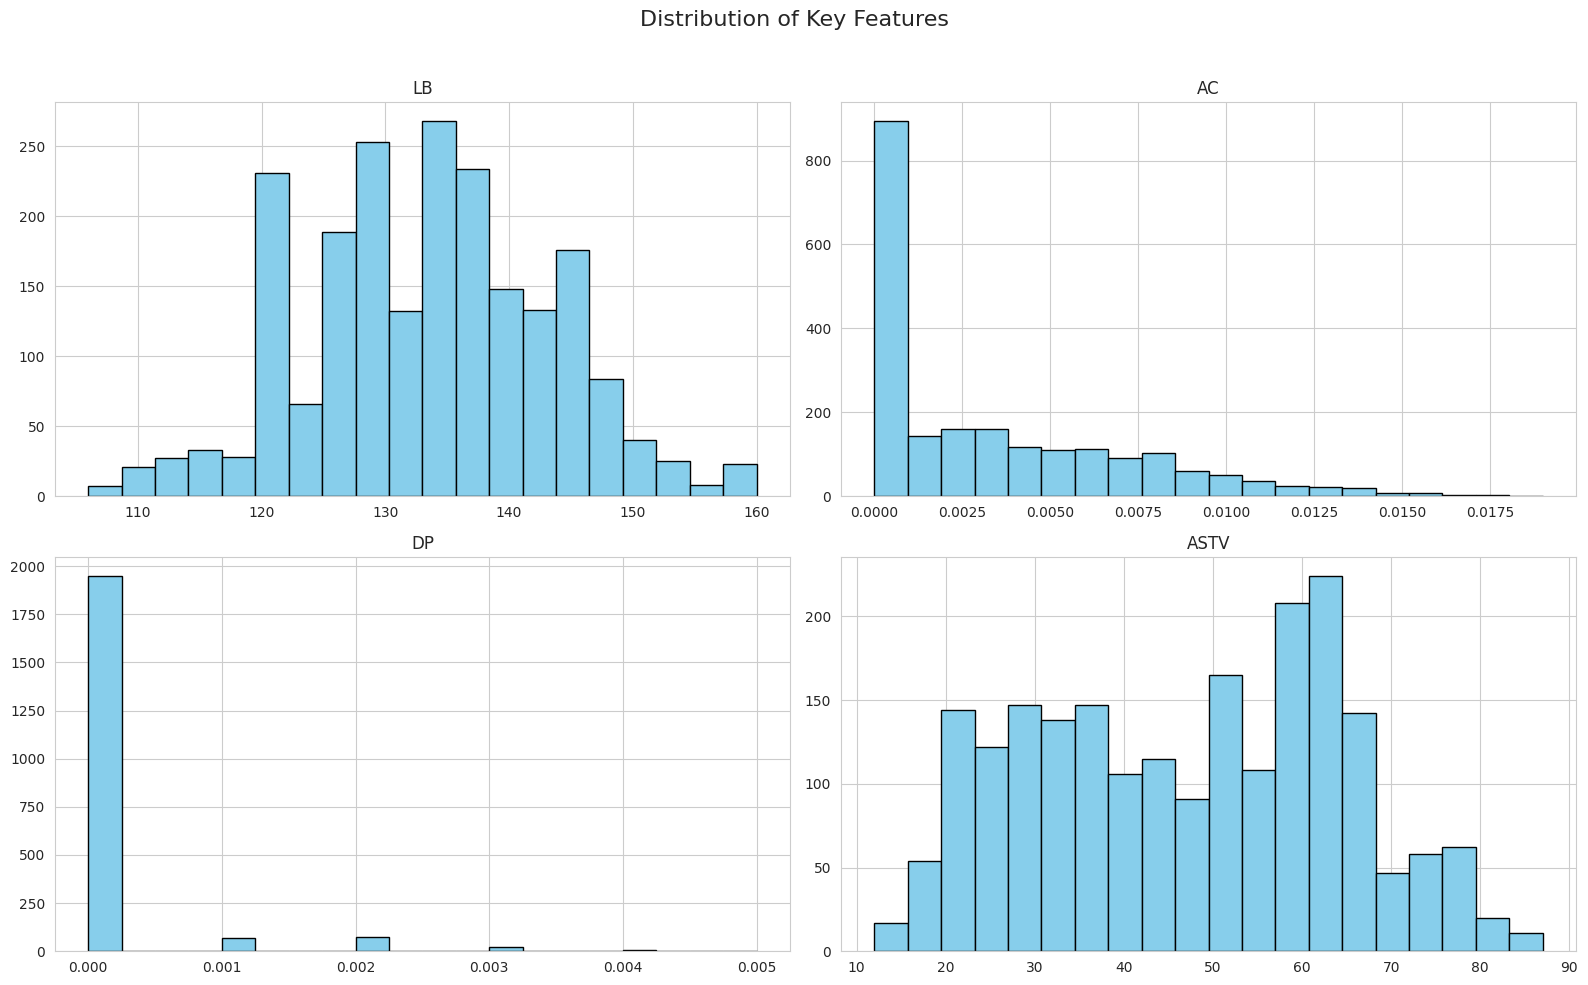


Comparing key features across health classes...


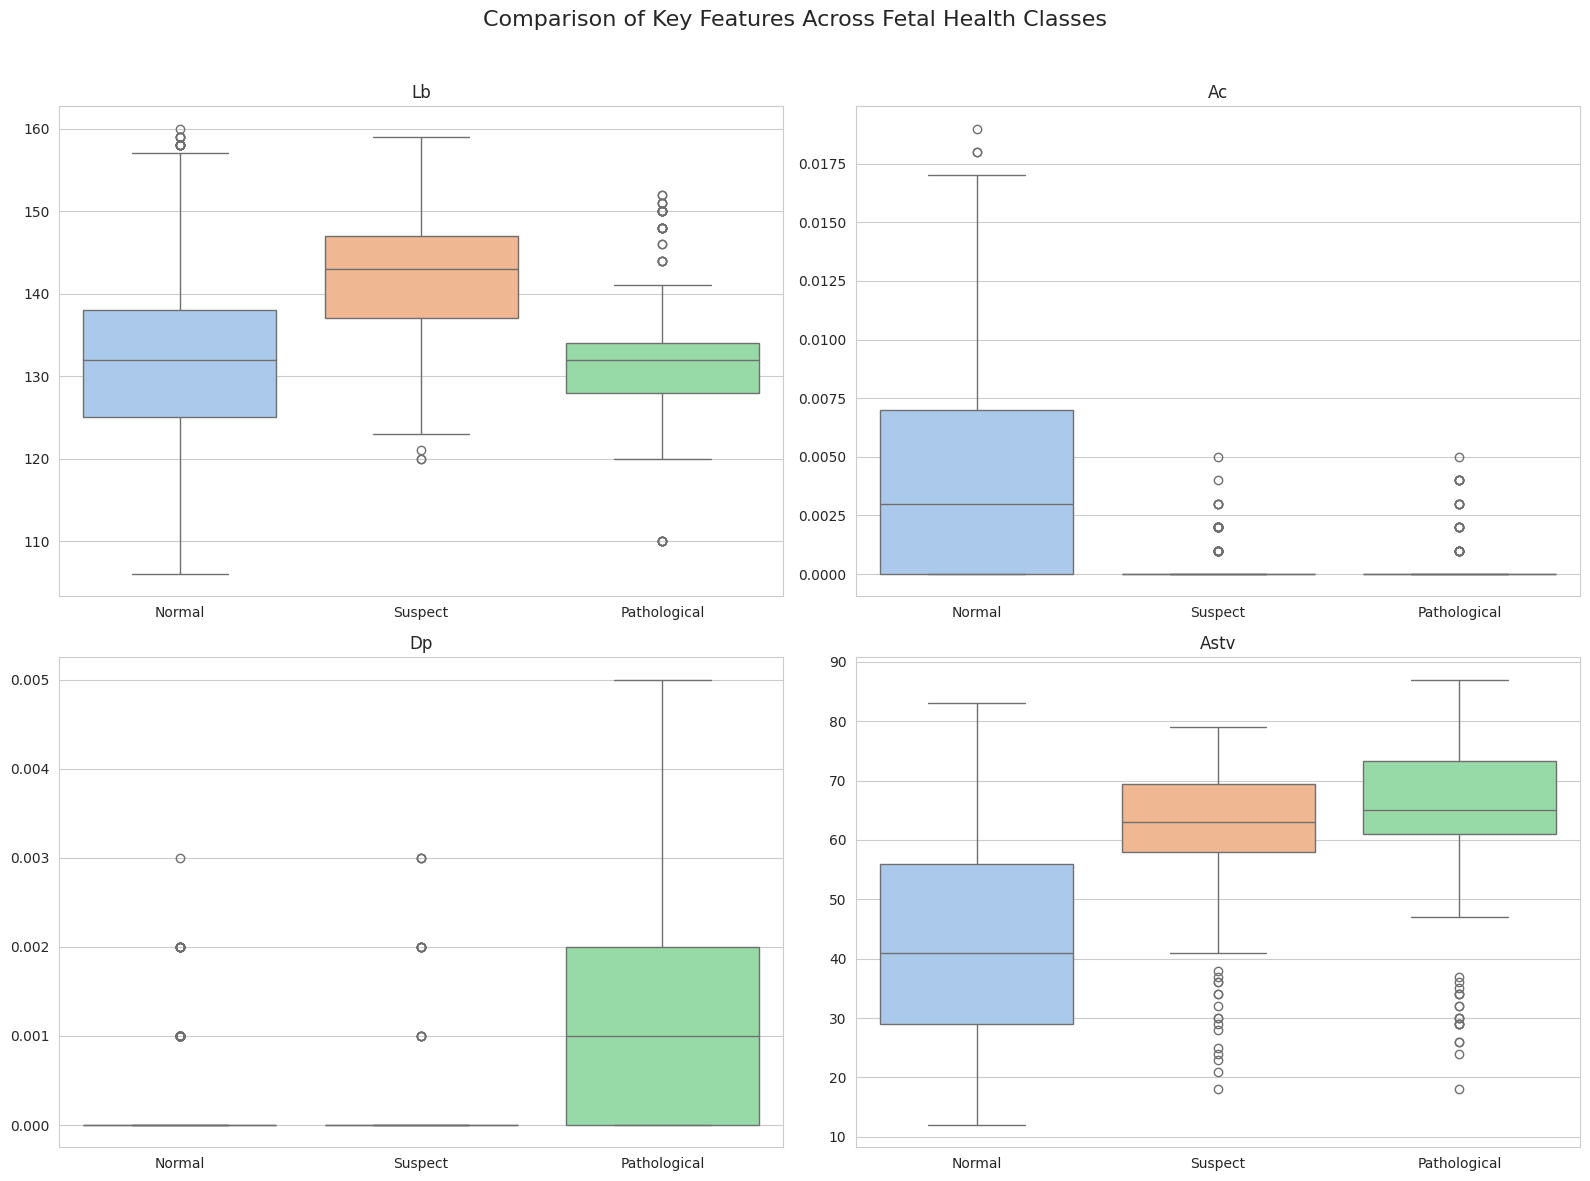


Visualizing feature correlations...


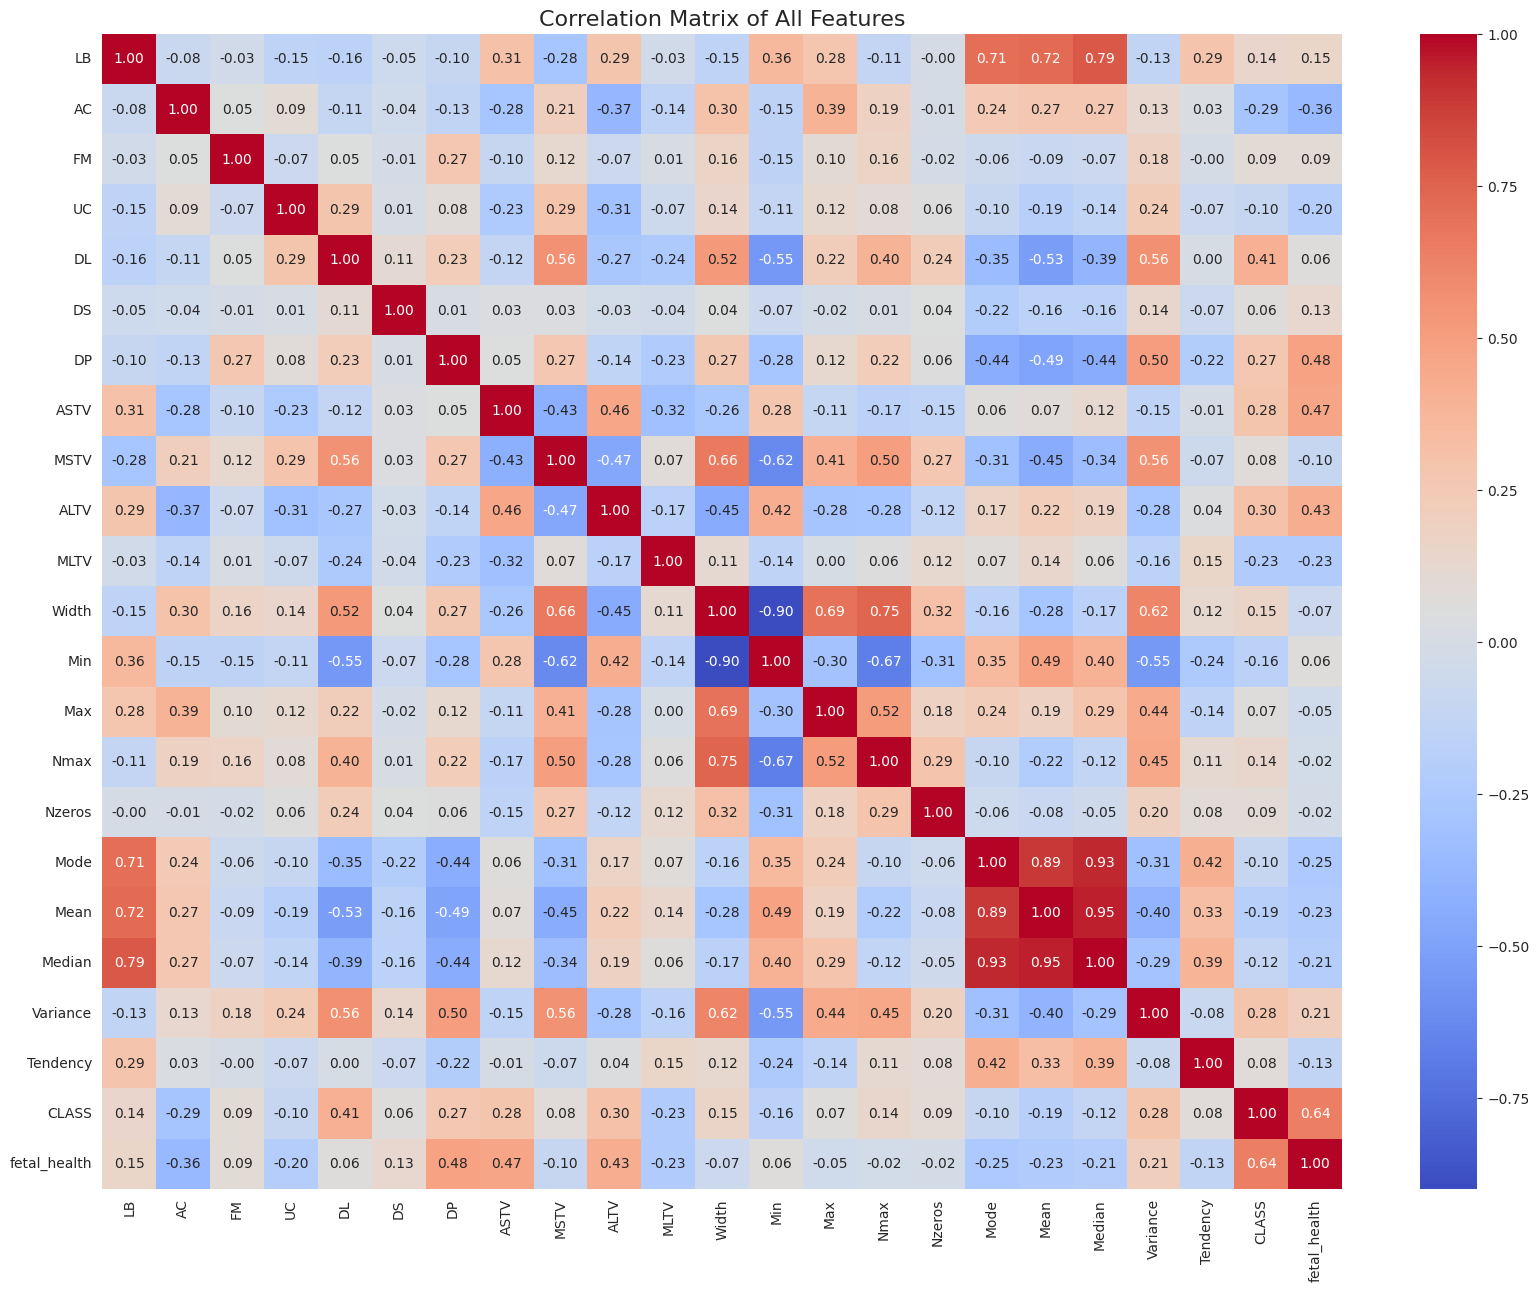

In [53]:
# 2. Explanatory Data Analysis

print("\n--- Starting Exploratory Data Analysis ---")

# For EDA, we'll work with a combined DataFrame for easier analysis
df_eda = pd.concat([X_raw, y_raw], axis=1)
df_eda.rename(columns={'NSP': 'fetal_health'}, inplace=True)
df_eda['fetal_health'] = df_eda['fetal_health'].astype(int)

# Histogram
print("\nPlotting feature distributions...")
# We will use the same key features for consistency
# First, let's define them robustly
feature_columns = X_raw.columns
key_features = [
    feature_columns[0],  # 'baseline value'
    feature_columns[1],  # 'accelerations'
    feature_columns[6],  # 'prolongued decelerations'
    feature_columns[7]   # 'abnormal short term variability'
]

df_eda[key_features].hist(bins=20, figsize=(16, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Key Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# BOX PLOT
print("\nComparing key features across health classes...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparison of Key Features Across Fetal Health Classes', fontsize=16)
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(x='fetal_health', y=feature, data=df_eda, ax=axes[i], palette='pastel')
    axes[i].set_title(feature.replace('_', ' ').title()) # Clean up title
    axes[i].set_xticklabels(['Normal', 'Suspect', 'Pathological'])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 3. HEAT MAP
print("\nVisualizing feature correlations...")
plt.figure(figsize=(20, 15))
corr_matrix = df_eda.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of All Features', fontsize=16)
plt.show()

In [54]:
#3. DATA PREPROCESSING

print("\n--- Preparing Data for Modeling ---")

# OUTLIER REMOVAL USING Z-SCORE
X_features = df.drop('fetal_health', axis=1)
y_target = df['fetal_health']


z_scores = np.abs(stats.zscore(X_features))
threshold = 3
non_outlier_indices = (z_scores < threshold).all(axis=1)
df_cleaned = df[non_outlier_indices]

print(f"Original number of samples: {len(df)}")
print(f"Number of samples after removing outliers: {len(df_cleaned)}")
print(f"Number of outliers removed: {len(df) - len(df_cleaned)}")

# Label Adjustment and Data Splitting
X = df_cleaned.drop('fetal_health', axis=1)
y = df_cleaned['fetal_health']
y = y - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data has been successfully cleaned, split, and scaled.")

#Helper Function for plotting
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal (1)', 'Suspect (2)', 'Pathological (3)'],
                yticklabels=['Normal (1)', 'Suspect (2)', 'Pathological (3)'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


--- Preparing Data for Modeling ---
Original number of samples: 2126
Number of samples after removing outliers: 1769
Number of outliers removed: 357
Data has been successfully cleaned, split, and scaled.


In [55]:
# Train XGBoost
print("Training XGBoost model...")
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

print("Model trained successfully.")

Training XGBoost model...
Model trained successfully.



 Model Reports 


 Report for: XGBoost 

1. Multi-class Accuracy: 0.9887

2. Per-class Report (Precision, Recall, F1-Score):
                  precision    recall  f1-score   support

      Normal (1)       0.99      0.99      0.99       296
     Suspect (2)       0.96      0.96      0.96        53
Pathological (3)       1.00      1.00      1.00         5

        accuracy                           0.99       354
       macro avg       0.99      0.99      0.99       354
    weighted avg       0.99      0.99      0.99       354


3. Confusion Matrix:


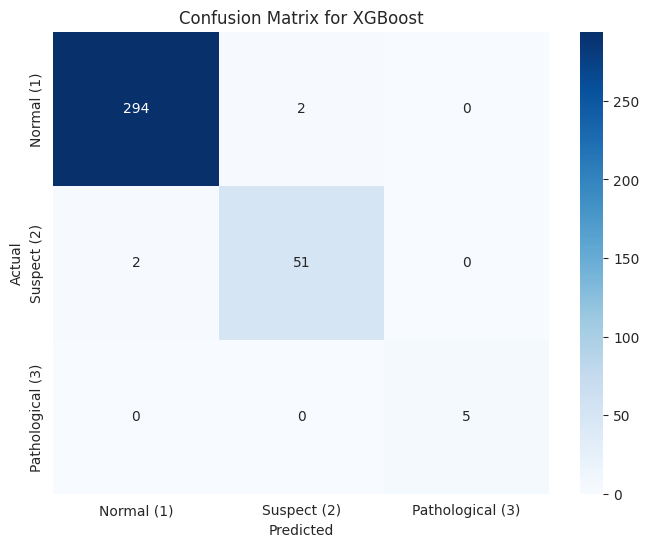

In [56]:
# MODEL VALIDATION

print("\n Model Reports ")


y_pred_xgb = xgb_model.predict(X_test_scaled)

#  plotting the confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    """Generates and displays a confusion matrix plot."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal (1)', 'Suspect (2)', 'Pathological (3)'],
                yticklabels=['Normal (1)', 'Suspect (2)', 'Pathological (3)'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


print("\n\n Report for: XGBoost ")

# 1. Multi-class Accuracy
print(f"\n1. Multi-class Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

# 2. Per-class Precision, Recall, F1-Score
print("\n2. Per-class Report (Precision, Recall, F1-Score):")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal (1)', 'Suspect (2)', 'Pathological (3)']))

# 3. Confusion Matrix
print("\n3. Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost')
